# ✈️ Travel Planner

## 📥 Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

## 📝 Problem Definition
This notebook provides an analysis of the `costs.csv` and `evaluation_results.csv`, obtained through our testing framework.

As our tests were conducted using the **Llama 3.1 8B** model, we will base our analysis on the average pricing across cloud platforms, as shown in the model pricing below or on [this link](https://www.llama.com/llama3_1/).

On average, the input cost is approximately **$0.31 per 1 million tokens**, while the output cost is around **$0.36 per 1 million tokens**.

<img src="model_pricing.png" alt="Llama 3.1 Model Pricing" width="600">


In [2]:
PRICING = {
    'input_cost_per_1m': 0.31,
    'output_cost_per_1m': 0.36
}

## Data

### Data loading

We will use two datasets obtained throughout our different tests :
- `costs.csv` corresponds to the token consumption for each step (flight/hotel/activity search, ...) when a user prompt is received by the agent
- `evaluation_results.csv` represents a batch of tests made with the [test_agent.py](../tests/test_agent.py) file and using the following [prompts](../tests/prompts.csv)

In [3]:
df_costs = pd.read_csv('../costs.csv')
df_results = pd.read_csv('../tests/evaluation_results.csv')
print("Files loaded successfully.")

Files loaded successfully.


### Data Preprocessing and Aggregation

We will now aggregate the different costs per testing scenario.
We need to sum up all API calls for a single user request to get the total cost/latency for that request.

Therefore we group using the `scenario_id` attribute.

In [4]:
cost_summary = df_costs.groupby('scenario_id').agg({
    'call_id': 'count',                 # Total API calls made
    'prompt_tokens': 'sum',
    'completion_tokens': 'sum',
    'total_tokens': 'sum',
    'latency_ms': 'sum',                # Total time taken
    'status': lambda x: (x == 'SUCCESS').mean()  # Success rate of internal calls
}).reset_index()

Let's now rename the column for clarity.

In [5]:
cost_summary.rename(columns={'call_id': 'num_api_calls', 'status': 'internal_success_rate'}, inplace=True)

We now need to merge `costs.csv` with `evaluation_results.csv` on `scenario_id` to get all the information needed in a single dataframe.

In [6]:
df_final = pd.merge(df_results, cost_summary, left_on='id', right_on='scenario_id')


For our tests, we will use three different features offered by our agent
- `Planner` : Allows the agent to plan its thinking process
- `Tools` : Allows the agent to interact with its environment (call to APIs)
- `Reasoning` : Allows the agent to think about the correctness of its answer

And we will tests three different architectures :
- `Planner + Tools + Reasoning`
- `Planner + Tools`
- `Planner only`

Note that configurations without the Planner were not tested, as the Planner is required for any meaningful itinerary generation.

In [7]:
def get_architecture_label(row):
    if row['use_planner'] and row['use_tools'] and row['use_reasoning']:
        return 'Planner + Tools + Reasoning'
    elif row['use_planner'] and row['use_tools']:
        return 'Planner + Tools'
    elif row['use_planner']:
        return 'Planner Only'
    else:
        return 'Baseline'
    
df_final['architecture'] = df_final.apply(get_architecture_label, axis=1)

Here we will compute the estimated financial cost (with the pricing defined earlier in the notebook).

In [8]:
df_final['estimated_cost_usd'] = (
    (df_final['prompt_tokens'] / 1_000_000 * PRICING['input_cost_per_1m']) +
    (df_final['completion_tokens'] / 1_000_000 * PRICING['output_cost_per_1m'])
)

In [9]:
print(f"Data processed. Total Scenarios: {len(df_final)}")
display(df_final.head())

Data processed. Total Scenarios: 54


,id,conditions,analysis,relevance,helpfulness,logic,use_reasoning,use_planner,use_tools,scenario_id,num_api_calls,prompt_tokens,completion_tokens,total_tokens,latency_ms,internal_success_rate,architecture,estimated_cost_usd
0,9f0bfa74-60d2-4e1c-b7e7-4f9539a41553,Should identify reasonable flight options from...,The AI's response is weak in terms of helpfuln...,10,2,5,0,1,1,9f0bfa74-60d2-4e1c-b7e7-4f9539a41553,4,1346,379,1725,36138.58,1.0,Planner + Tools,0.000554
1,0cbb028e-a379-469c-b1da-3566b5de265d,Should identify flights from London to the Mal...,The AI's response is weak in terms of helpfuln...,10,2,5,0,1,1,0cbb028e-a379-469c-b1da-3566b5de265d,4,1328,311,1639,32121.71,1.0,Planner + Tools,0.000524
2,8cba4d7d-a3de-451b-96bb-9918cd72a328,Should propose a logical travel route through ...,The AI response provides a detailed itinerary ...,9,8,9,0,1,1,8cba4d7d-a3de-451b-96bb-9918cd72a328,7,4102,1134,5236,112899.28,1.0,Planner + Tools,0.001680
3,0b6353ea-3f78-4b94-8ecd-8ae611dc6083,Should identify business-class flight options ...,The AI response correctly identifies the user'...,9,7,8,0,1,1,0b6353ea-3f78-4b94-8ecd-8ae611dc6083,7,3389,1009,4398,114119.06,1.0,Planner + Tools,0.001414
4,1f82b2b1-c004-4b88-83b8-a0047e50fdc3,Should suggest suitable accommodation for four...,The AI's response is weak in terms of relevanc...,2,1,10,0,1,1,1f82b2b1-c004-4b88-83b8-a0047e50fdc3,4,1310,273,1583,37257.43,1.0,Planner + Tools,0.000504


## Analysis
### Cost Analysis (Token Consumption)

In [25]:
mean_df = (
    df_final
    .groupby('architecture', as_index=False)['total_tokens']
    .mean()
)

mean_cost_df = (
    df_final
    .groupby('architecture', as_index=False)['estimated_cost_usd']
    .mean()
)

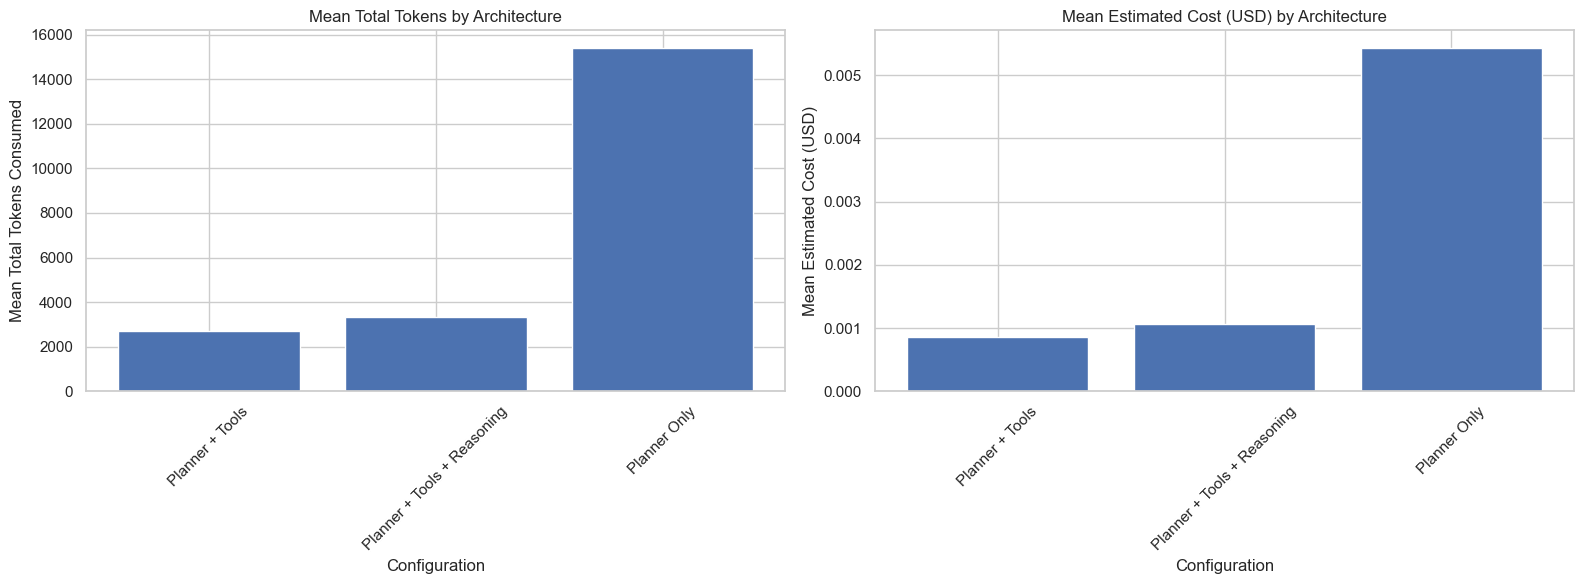

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Mean total tokens
axes[0].bar(mean_df['architecture'], mean_df['total_tokens'])
axes[0].set_title('Mean Total Tokens by Architecture')
axes[0].set_ylabel('Mean Total Tokens Consumed')
axes[0].set_xlabel('Configuration')
axes[0].tick_params(axis='x', rotation=45)

# Plot 2: Mean estimated cost
axes[1].bar(mean_cost_df['architecture'], mean_cost_df['estimated_cost_usd'])
axes[1].set_title('Mean Estimated Cost (USD) by Architecture')
axes[1].set_ylabel('Mean Estimated Cost (USD)')
axes[1].set_xlabel('Configuration')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

As illustrated in the two graphs, there is a significant disparity in token efficiency (and therefore final costs) across the three architectural configurations. 

The **Planner Only** configuration exhibited the highest consumption, averaging approximately 15,000 tokens per process. In contrast, the **Planner + Tools** architecture was the most efficient $\approx$ 2,600 tokens, while the addition of the **Reasoning** module increased consumption only marginally to $\approx$ 3,200 tokens.


### Quality Analysis (Helpfulness Score)

/var/folders/pg/1l4d75p90r565jztmcw4v8c00000gn/T/ipykernel_20207/4201731265.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='architecture', y='helpfulness', data=df_final, palette="Greens")


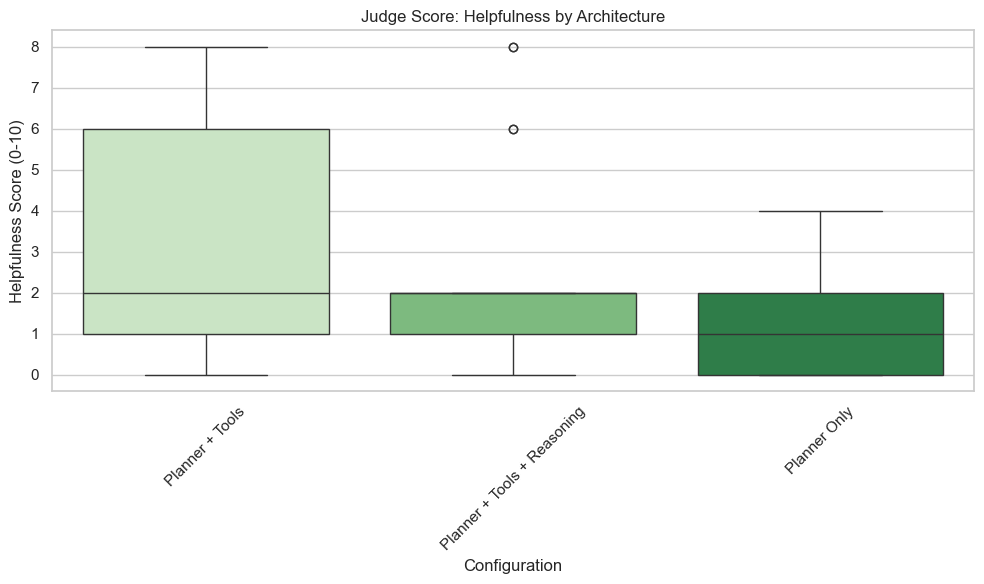

In [19]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='architecture', y='helpfulness', data=df_final, palette="Greens")
plt.title('Judge Score: Helpfulness by Architecture')
plt.ylabel('Helpfulness Score (0-10)')
plt.xlabel('Configuration')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The data suggests that adding Tools to the Planner significantly increases the potential for high helpfulness scores, though it introduces high variability. Surprisingly, adding Reasoning on top of tools appears to degrade performance for the majority of cases, compressing scores to the lower end of the spectrum, with only a few successful outliers.

### Latency Analysis

/var/folders/pg/1l4d75p90r565jztmcw4v8c00000gn/T/ipykernel_20207/2757414983.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='architecture', y='latency_ms', data=df_final, palette="Oranges", errorbar='sd')


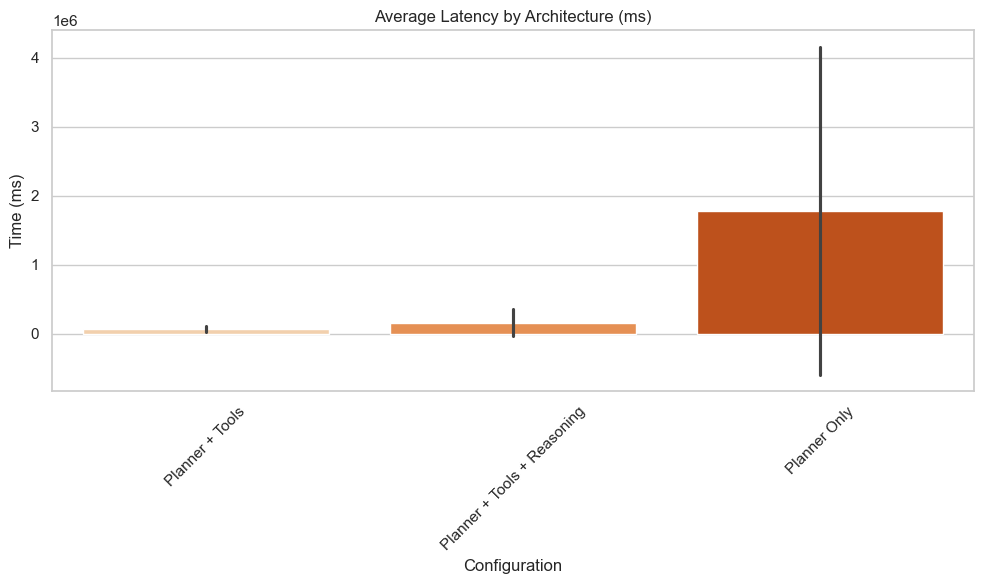

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x='architecture', y='latency_ms', data=df_final, palette="Oranges", errorbar='sd')
plt.title('Average Latency by Architecture (ms)')
plt.ylabel('Time (ms)')
plt.xlabel('Configuration')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Similarly to the cost, we see that the planner + tools take less time to use the different needed tools than the two other architectures.

## Efficiency metrics

### Efficiency Scatter Plot

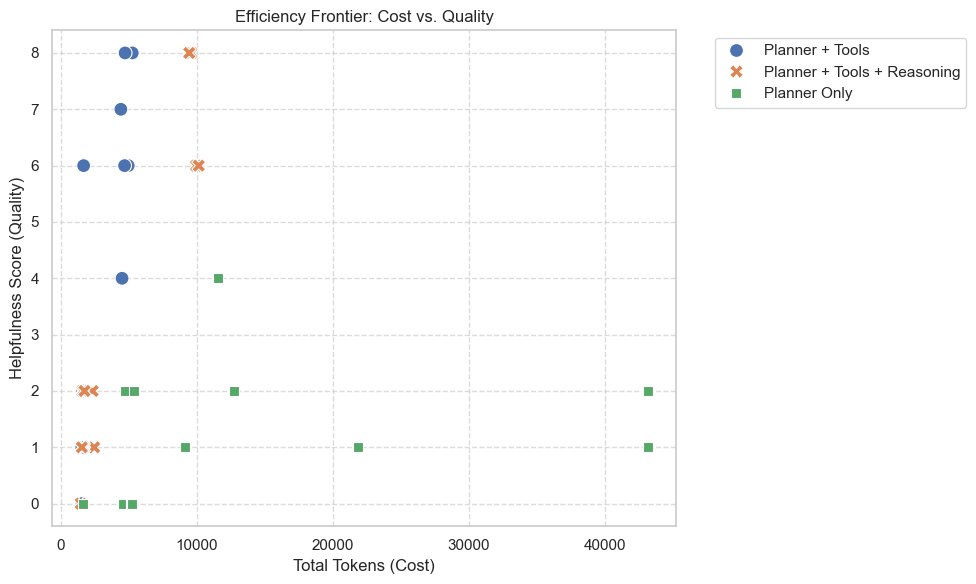

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_final, 
    x='total_tokens', 
    y='helpfulness', 
    hue='architecture', 
    style='architecture', 
    s=100
)
plt.title('Efficiency Frontier: Cost vs. Quality')
plt.xlabel('Total Tokens (Cost)')
plt.ylabel('Helpfulness Score (Quality)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

The figure illustrates that, on average, the Planner + Tools architecture achieves the most favorable balance between helpfulness scores and total token usage. 

By comparison, the Planner Only approach consumes substantially more tokens while producing less informative responses, largely due to its reliance on fully generated content.

### Performance Summary table

In [23]:
df_final['efficiency_ratio'] = df_final['total_tokens'] / (df_final['helpfulness'] + 0.1)

print("\n--- PERFORMANCE SUMMARY TABLE ---")
summary_table = (
    df_final
    .groupby('architecture')
    .agg(
        total_tokens_mean=('total_tokens', 'mean'),
        latency_ms_mean=('latency_ms', 'mean'),
        helpfulness_mean=('helpfulness', 'mean'),
        helpfulness_var=('helpfulness', 'var'),
        logic_mean=('logic', 'mean'),
        logic_var=('logic', 'var'),
        efficiency_ratio_mean=('efficiency_ratio', 'mean'),
    )
    .round(2)
    .sort_values('helpfulness_mean', ascending=False)
)

summary_table



--- PERFORMANCE SUMMARY TABLE ---


,total_tokens_mean,latency_ms_mean,helpfulness_mean,helpfulness_var,logic_mean,logic_var,efficiency_ratio_mean
architecture,,,,,,,
Planner + Tools,2703.95,68945.97,3.35,7.29,7.65,6.03,1671.49
Planner + Tools + Reasoning,3325.90,162084.88,2.60,5.62,7.50,7.53,1849.15
Planner Only,15413.36,1780155.16,1.21,1.41,8.57,8.26,23857.96


While helpfulness remains relatively low across the three architectures, logic scores are consistently high, with the Planner only architecture achieving the highest values due to its ability to generate prompt-specific responses without relying on APIs.

At the same time, performance variance is considerable, largely because many executions failed to retrieve the necessary information from external APIs.

## Conclusion 

The different counter-intuitive presented results, where for example the reasoning has a worse score then the non reasoning version or where the planner take significantly more time to responde, can be explained by the following factors:

- **Hallucination vs. Structured Data**:
    - The "Planner Only" architecture lacks access to external APIs. Consequently, it is forced to "hallucinate" or invent realistic details for flights, hotels, and activities. To make these fabrications convincing, the model tends to generate highly verbose and elaborate descriptions. In contrast, the tool-enabled agents receive concise, structured JSON data from the APIs, which requires significantly fewer tokens to process and represent.

- **Impact of API Limitations on Reasoning**:
    - The "Planner + Tools + Reasoning" configuration consumes only slightly more tokens than the standard tool-based architecture. This limited increase suggests that the reflection loop was not triggered as frequently or intensively as expected. This is likely due to the constraints of the free-tier APIs used (Amadeus). Frequent data unavailability or "dummy" responses may have simplified the resulting itineraries, leading the "Reviewer" agent to approve plans quickly or fail early, rather than engaging in expensive, multi-turn iterative corrections.


Therefore time-wise and cost-wise, using only the planner and the tools gives the best-value answers when using our agent.